## Librerias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob
import tqdm
import pandas as pd
import tensorflow as tf
import os


In [ ]:
#@title API KAGGLE
! pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
#@title Guarda Dataset
Dataset_Existente = False #@param {type:"boolean"}
if Dataset_Existente==False:
    ! mkdir ~/.kaggle
    ! cp kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json
    #! kaggle datasets list
    ! kaggle datasets download jfgm2018/the-simpsons-dataset-compilation-49-characters 
    ! unzip /content/the-simpsons-dataset-compilation-49-characters.zip

In [ ]:
path='/content/simpson/'

In [ ]:
files=glob.glob(path+"**/*.jpg",recursive=True)
print("Numero de imagenes {}".format(len(files)))

Numero de imagenes 34455


In [231]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [189]:
#@title Funciones 

class Preprocessing():
    def __init__(self) -> None:
        pass

    def read_and_decode(self, filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_image(img, channels=3,expand_animations=False)
        img = tf.image.convert_image_dtype(img, tf.uint8)
        return img
      

    def preprocess_image(self, img, width=128, height=128,to_bytes=True):
        if (img.shape[0] < width and img.shape[1] < height):
            img = tf.image.resize(img, [width, height],
                                  preserve_aspect_ratio=True)
        if img.shape[0] > width:
            img = tf.image.resize(img, [int(width*1.3), int(height*1.3)],
                                  preserve_aspect_ratio=True)
        img = tf.image.resize_with_crop_or_pad(img,
                                               target_width=width,
                                               target_height=height)
        if to_bytes==True:
            img=tf.cast(img,tf.uint8)
            img=tf.image.encode_jpeg(img).numpy()
            return img
        img=tf.cast(img,tf.uint8)
        return img.numpy()

## Ejemplos de Preprocesamiento

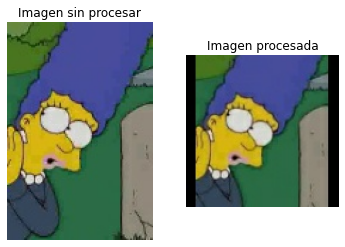

In [202]:
test_prepro=Preprocessing()
img=test_prepro.read_and_decode(files[500])

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Imagen sin procesar")
plt.axis('off')

img=test_prepro.preprocess_image(img,to_bytes=True)
img = tf.image.decode_jpeg(img, channels=3) #Decodificar si to_bytes=True
plt.subplot(1,2,2)
plt.imshow(img)
plt.title("Imagen procesada")
plt.axis('off')
plt.show()

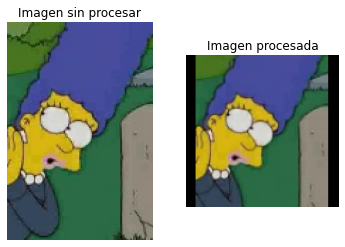

In [201]:
test_prepro=Preprocessing()
img=test_prepro.read_and_decode(files[500])

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Imagen sin procesar")
plt.axis('off')

img=test_prepro.preprocess_image(img,to_bytes=False)
plt.subplot(1,2,2)  # No se requiere decodificar, puesto que se obtiene un array int8
plt.imshow(img)
plt.title("Imagen procesada")
plt.axis('off')
plt.show()

## Creación de archivos TFRecords

In [ ]:
def _serialize_sample(image):
    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image]))
    }
    sample = tf.train.Example(features=tf.train.Features(feature=feature))
    return sample.SerializeToString()


In [ ]:
def create_files(data,set_name, Num_Files, path):
    i = 0
    num_elements_per_file=len(data)//Num_Files
    np.random.shuffle(data)
    np.random.shuffle(data)
    for file in tqdm.tqdm(range(Num_Files)):
        start=i*num_elements_per_file
        end=start+num_elements_per_file

        paths_to_imgs=data[start:end]
      
        serialize = Preprocessing()
        imgs = list(map(serialize.preprocess_image,
                    list(map(serialize.read_and_decode, paths_to_imgs))))
        
        with tf.io.TFRecordWriter(path+set_name+"_"+str(file).zfill(2)+".tfrec") as writer:
            for img_one in imgs:
                writer.write(_serialize_sample(img_one))
            writer.close()
        i += 1


In [ ]:
create_files(data=files,set_name='simpson_data', Num_Files=20, path='/content/data_tfrec/')


100%|██████████| 20/20 [02:42<00:00,  8.11s/it]


**Notar que el Dataset completo pesa 275M con archivos .tfrec**

In [203]:
!du -h /content/data_tfrec/

4.0K	/content/data_tfrec/.ipynb_checkpoints
275M	/content/data_tfrec/


### Lectura de archivos TFRecords

In [ ]:
feature_map = {
    'image': tf.io.FixedLenFeature([], tf.string),
}

In [ ]:
def read_tf_record(example):
    example = tf.io.parse_single_example(example, feature_map)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    return image


def get_dataset(filename):
    dataset = tf.data.TFRecordDataset(filename)
    dataset = dataset.map(read_tf_record)
    return dataset


In [ ]:
batch1 = get_dataset('/content/data_tfrec/simpson_data_00.tfrec')
print(len(list(batch1.as_numpy_iterator())))

1722


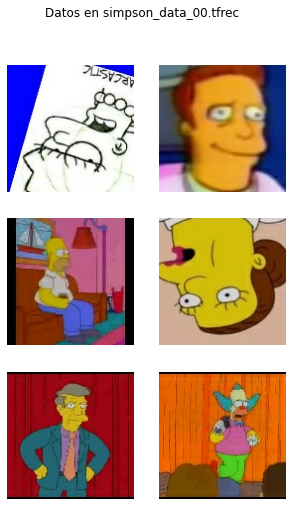

In [ ]:
plt.figure(figsize=(5,8))
plt.suptitle("Datos en simpson_data_00.tfrec")
for ind,val in enumerate(batch1.take(6)):
        plt.subplot(3,2,ind+1)
        plt.imshow(val)
        plt.axis('off')
#plt.tight_layout()
plt.show()

## Creación de archivos Pickle

In [ ]:
import pickle

def create_files_pickle(data,set_name, Num_Files, path):
    i = 0
    num_elements_per_file=len(data)//Num_Files
    np.random.shuffle(data)
    np.random.shuffle(data)
    for file in tqdm.tqdm(range(Num_Files)):
        start=i*num_elements_per_file
        end=start+num_elements_per_file

        paths_to_imgs=data[start:end]
      
        serialize = Preprocessing()
        imgs = list(map(serialize.preprocess_image,
                    list(map(serialize.read_and_decode, paths_to_imgs))))
        
        with open(path+'simpsons_set'+str(file).zfill(2)+'.pickle','wb') as f:
            pickle.dump(imgs,f)

        i += 1

In [ ]:
create_files_pickle(data=files,set_name='simpson_data', Num_Files=20, path='/content/data_pickle/')

100%|██████████| 20/20 [02:45<00:00,  8.26s/it]


**Los archivos pickle pesan lo mismo que los .tfrec**

Lo importante aqui es que no se usan arreglos, si no strings*

In [204]:
!du -h /content/data_pickle/

274M	/content/data_pickle/


### Lectura de archivos pickle

In [ ]:
with open("/content/data_pickle/simpsons_set00.pickle",'rb') as f:
    imgs = pickle.load(f)

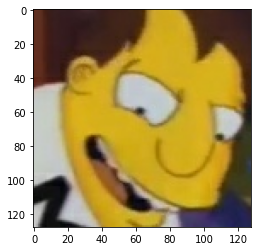

In [ ]:
plt.imshow(tf.image.decode_jpeg(imgs[1]))

## Creación de archivos Pickle (Full Numpy Arrays)

In [223]:
def create_files_pickle_np(data,set_name, Num_Files, path):
    i = 0
    num_elements_per_file=len(data)//Num_Files
    np.random.shuffle(data)
    np.random.shuffle(data)
    for file in tqdm.tqdm(range(Num_Files)):
        start=i*num_elements_per_file
        end=start+num_elements_per_file

        paths_to_imgs=data[start:end]
      
        serialize = Preprocessing()
   
        imgs3=[]
        for path1 in paths_to_imgs:
            a=serialize.read_and_decode(path1)
            b=serialize.preprocess_image(a,to_bytes=False) #Devuleve un arreglo de enteros
        
            imgs3.append(b)
        imgs3=np.array(imgs3)
        with open(path+'simpsons_setnp_'+str(file).zfill(2)+'.pickle','wb') as f:
            pickle.dump(imgs3,f)

        i += 1

In [224]:
create_files_pickle_np(data=files,set_name='simpson_data', Num_Files=20, path="/content/data_pickle_np/")

100%|██████████| 20/20 [02:53<00:00,  8.69s/it]


El peso de los archivos se eleva de 275 M a 1.6G

In [240]:
!du -sh /content/data_pickle_np/

1.6G	/content/data_pickle_np/


El dataset con imagenes pesa:

In [239]:
!du -sh /content/simpson

2.0G	/content/simpson


Estos resultados podrian tomarse en cuenta para manejar los archivos pickle. 

### Lectura de archivos pickle (full numpy array)

In [226]:
with open("/content/data_pickle_np/simpsons_setnp_00.pickle",'rb') as g:
    imgs = pickle.load(g)

In [227]:
len(imgs)

1722

In [228]:
imgs[1]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

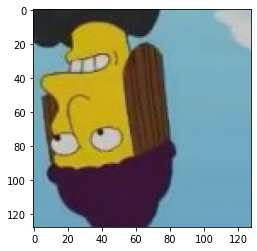

In [229]:
plt.imshow(imgs[0])

In [234]:
!cp -R /content/data_tfrec /content/drive/MyDrive/Dataset/Simpson/

In [235]:
!cp -R /content/data_pickle /content/drive/MyDrive/Dataset/Simpson/

In [241]:
!cp -R /content/simpson /content/drive/MyDrive/Dataset/Simpson/

Los siguientes Notebook cargaran el dataset desde drive